# Neural Network Training Techniques

## Batch Normalization Study

This notebook demonstrates the impact of batch normalization on neural network training by comparing two architectures:
1. A baseline feed-forward network
2. The same architecture enhanced with batch normalization layers

Both networks are trained on the FashionMNIST dataset to empirically compare convergence speed and final performance.

## Batch Normalization
In this study we construct a feed forward neural network with batch normalization during training. Training deep neural networks can be challenging due to the change in the distribution of inputs to layers deep in the network as a result of the updates of the weights in the previous layers. This causes the learning to chase a "moving target", which slows down the learning process. Batch normalization is a technique that aims to address this problem by normalizing layer inputs. This stabilizes the learning process and can greatly decrease training time. If you are interested you can read the paper introducing batch normalization [here](https://arxiv.org/abs/1502.03167).

We will be working with the [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) dataset by Zalando, which consists of $28\times 28$ black and white images and has 10 classes just like the [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) dataset. But instead of numbers the classes are various items of clothing such as shoes, t-shirts, dresses, etc.

### Baseline Network
We construct a feed forward neural network with 3 hidden linear layers with a ReLU after each of the first 2 layers. The first layer has a hidden size of 64 and the second a hidden size of 32. This is a multi-class classification problem so we use cross entropy loss (provided by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)). We use stochastic gradient descent (provided by [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) with a learning rate of 0.001 as the optimizer. The network is trained on the training data for 5 epochs and accuracy on the **test** set is reported after each epoch, for this refer to [PyTorch Training Loop](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) and [Per-Epoch Activity](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#per-epoch-activity).

**Note**: The data comes in the format of $28 \times 28$ tensors, so we flatten it before training.

In [6]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm

In [7]:
# load train and test set
fashion_trainset = torchvision.datasets.FashionMNIST('data/', train=True, download=True, transform=transforms.ToTensor())
fashion_testset = torchvision.datasets.FashionMNIST('data/', train=False, download=True, transform=transforms.ToTensor())

In [8]:
# get train and test loader
fashion_train_loader = torch.utils.data.DataLoader(dataset=fashion_trainset, batch_size=64, shuffle=True)
fashion_test_loader = torch.utils.data.DataLoader(dataset=fashion_testset, batch_size=64, shuffle=False)

In [9]:
# Define the network
class FashionNetwork(nn.Module):
    def __init__(self):
        super(FashionNetwork, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(28 * 28, 64)  # Input size is flattened 28x28 images
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)  # Output size is 10 for 10 classes

        # Activation function
        self.relu = nn.ReLU()

        # Define loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def optimize(self, train_loader, test_loader, epochs=5, lr=0.001):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        accuracies = []

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            # Test after each epoch
            accuracy = self.test(test_loader)
            accuracies.append(accuracy)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy:.2f}%")

        return accuracies

    def test(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy

In [10]:
fashion_network = FashionNetwork()
fashion_network.optimize(fashion_train_loader, fashion_test_loader)

Epoch 1/5: 100%|██████████| 938/938 [00:07<00:00, 123.27it/s]


Epoch 1/5, Loss: 2.273115596537397, Accuracy: 20.43%


Epoch 2/5: 100%|██████████| 938/938 [00:07<00:00, 126.29it/s]


Epoch 2/5, Loss: 2.180704350410494, Accuracy: 31.87%


Epoch 3/5: 100%|██████████| 938/938 [00:07<00:00, 128.48it/s]


Epoch 3/5, Loss: 2.001620740143221, Accuracy: 42.40%


Epoch 4/5: 100%|██████████| 938/938 [00:07<00:00, 130.72it/s]


Epoch 4/5, Loss: 1.7236336211660015, Accuracy: 45.02%


Epoch 5/5: 100%|██████████| 938/938 [00:07<00:00, 126.14it/s]


Epoch 5/5, Loss: 1.455630778885091, Accuracy: 56.32%


[20.43, 31.87, 42.4, 45.02, 56.32]

### Network with Batch Normalization
We construct another network with the same parameters as the baseline but this time include a batch normalization layer (refer to [nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)) after the hidden layers before the activation function. Train the network and save the test accuracies.

In [11]:
class FashionNetworkBatchNorm(nn.Module):
    def __init__(self):
        super(FashionNetworkBatchNorm, self).__init__()
        # Define the layers with batch normalization
        self.fc1 = nn.Linear(28 * 28, 64)
        self.bn1 = nn.BatchNorm1d(64)  # Batch normalization for the first hidden layer
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)  # Batch normalization for the second hidden layer
        self.fc3 = nn.Linear(32, 10)

        # Activation function
        self.relu = nn.ReLU()

        # Define loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.relu(self.bn1(self.fc1(x)))  # First layer with batch norm
        x = self.relu(self.bn2(self.fc2(x)))  # Second layer with batch norm
        x = self.fc3(x)  # Output layer
        return x

    def optimize(self, train_loader, test_loader, epochs=5, lr=0.001):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        accuracies = []

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            # Test after each epoch
            accuracy = self.test(test_loader)
            accuracies.append(accuracy)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy:.2f}%")

        return accuracies

    def test(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy


In [12]:
fashion_network_batch_norm = FashionNetworkBatchNorm()
fashion_network_batch_norm.optimize(fashion_train_loader, fashion_test_loader)

Epoch 1/5: 100%|██████████| 938/938 [00:07<00:00, 121.47it/s]


Epoch 1/5, Loss: 1.6081309706163305, Accuracy: 71.55%


Epoch 2/5: 100%|██████████| 938/938 [00:07<00:00, 124.41it/s]


Epoch 2/5, Loss: 1.171795835563623, Accuracy: 76.19%


Epoch 3/5: 100%|██████████| 938/938 [00:07<00:00, 129.27it/s]


Epoch 3/5, Loss: 0.9501513421281315, Accuracy: 78.14%


Epoch 4/5: 100%|██████████| 938/938 [00:07<00:00, 120.68it/s]


Epoch 4/5, Loss: 0.8093418564750696, Accuracy: 79.43%


Epoch 5/5: 100%|██████████| 938/938 [00:07<00:00, 120.64it/s]


Epoch 5/5, Loss: 0.7150960768590858, Accuracy: 80.56%


[71.55, 76.19, 78.14, 79.43, 80.56]

### Performance Comparison
We plot the accuracies of the two networks and analyze the results.

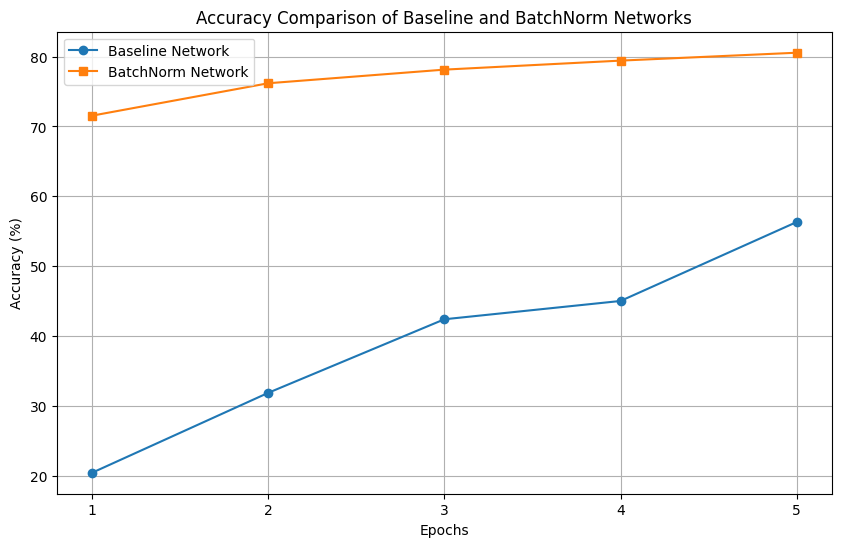

In [13]:
baseline_accuracies = [20.43, 31.87, 42.40, 45.02, 56.32]
batch_norm_accuracies = [71.55, 76.19, 78.14, 79.43, 80.56]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), baseline_accuracies, marker='o', label='Baseline Network')
plt.plot(range(1, 6), batch_norm_accuracies, marker='s', label='BatchNorm Network')
plt.title('Accuracy Comparison of Baseline and BatchNorm Networks')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()



**Analysis:**

**Observations:**

**Faster Convergence:** The network with batch normalization achieves higher accuracy earlier in the training process compared to the baseline network.


**Higher Accuracy:** By the end of the 5 epochs, the network with batch normalization has a consistently higher accuracy than the baseline.


**Stability:** Batch normalization reduces fluctuations in accuracy between epochs, stabilizing the learning process.